In [79]:
from imagem import Imagem
from glob import glob
import Functions as fc
import numpy as np
from skimage.io import imread,imshow,imsave,imread_collection
import cv2
from skimage.exposure import equalize_hist
from skimage.filters import median
from IPython.display import clear_output
from tqdm import tqdm
import seaborn as sns
import time
from sklearn.decomposition import PCA
from skimage.feature import greycomatrix, greycoprops
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score as acc
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import cohen_kappa_score, make_scorer, accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split

In [37]:
originais = sorted(glob(f'./imagens/*/*', recursive=True))

imgs = {
    'daisy': sorted(glob(f'./imagens/daisy/*', recursive=True)),
    'dandelion': sorted(glob(f'./imagens/dandelion/*', recursive=True)),
    'rose': sorted(glob(f'./imagens/rose/*', recursive=True)),
    'sunflower': sorted(glob(f'./imagens/sunflower/*', recursive=True)),
    'tulip': sorted(glob(f'./imagens/tulip/*', recursive=True))
}

In [4]:
def poeInt(imagem):
    linhas, colunas = imagem.shape
    copy = np.zeros((linhas, colunas), dtype=np.uint8)
    for l in range(linhas):
        for c in range(colunas):
                if imagem[l][c] == True:
                    copy[l][c] = 255
    return copy

In [5]:
def lerTodos(originais):
    imgs = []
    for i in tqdm(originais, desc='Imagens:  '):
        img = Imagem(i)
        img.ler()
        img.filtros['eq'] = img.equalize()
        img.filtros['median'] = median(img.filtros['eq'] )
        #img.filtros['otsu'] = fc.aplicaOtsu(img.filtros['median'])
        imgs.append(img)
    
    for i in tqdm(imgs, desc='Otsu:  '):
        i.filtros['otsu'] = {
            'r': poeInt(fc.aplicaOtsu(i.filtros['median'][:,:,0])),
            'g': poeInt(fc.aplicaOtsu(i.filtros['median'][:,:,1])),
            'b': poeInt(fc.aplicaOtsu(i.filtros['median'][:,:,2]))
        }

        i.filtros['inteiro'] = i.inteiro()

        i.filtros['otsu']['rgb'] = {
            'red': cv2.merge(
                (
                    i.filtros['otsu']['r'],
                    i.filtros['inteiro'][:,:,1],
                    i.filtros['inteiro'][:,:,2]
                )
            ),
            'green': cv2.merge(
                (
                    i.filtros['inteiro'][:,:,0],
                    i.filtros['otsu']['g'],
                    i.filtros['inteiro'][:,:,2]
                )
            ),
            'blue': cv2.merge(
                (
                    i.filtros['inteiro'][:,:,0],
                    i.filtros['inteiro'][:,:,1],
                    i.filtros['otsu']['b']
                )
            )
        }
        
        

    return imgs

In [6]:
imagens = lerTodos(originais)

Otsu:  : 100%|██████████| 500/500 [01:11<00:00,  7.01it/s]


In [38]:
red = imread_collection(sorted(glob(f'./otsu/red/*/*', recursive=True)))
green = imread_collection(sorted(glob(f'./otsu/green/*/*', recursive=True)))
blue = imread_collection(sorted(glob(f'./otsu/blue/*/*', recursive=True)))

In [13]:
""" imagens[0].salvar(red, originais, caminho='./otsu/red')
imagens[0].salvar(green, originais, caminho='./otsu/green')
imagens[0].salvar(blue, originais, caminho='./otsu/blue') """

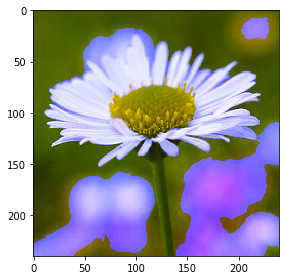

In [15]:
imshow(imagens[0].filtros['otsu']['rgb']['blue'])

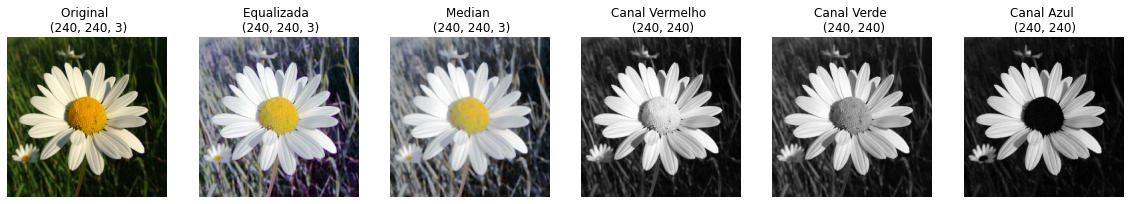

In [16]:
imagens[9].shows(5)

In [12]:
labels = []
labelsInt = []
k = 0
for j in ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']:
    for i in range(100):
        labels.append(j)
        labelsInt.append(k)
    k += 1

---
# Descritores

In [39]:
def aplicaGLCM(images, labels):
    features = np.zeros((len(labels),18)) #6 features x 3 color channels
    start = time.time()
    d = 5
    for id_im,imagem in enumerate(images):
        clear_output(wait=True)
        print('Extraindo atributos: {} imagens processadas de {}.'.format(id_im+1,len(images)))
        for id_ch in range(3):
            matrix0 = greycomatrix(imagem[:,:,id_ch], [d], [0],normed=True)
            matrix1 = greycomatrix(imagem[:,:,id_ch], [d], [np.pi/4],normed=True)
            matrix2 = greycomatrix(imagem[:,:,id_ch], [d], [np.pi/2],normed=True)
            matrix3 = greycomatrix(imagem[:,:,id_ch], [d], [3*np.pi/4],normed=True)
            matrix = (matrix0+matrix1+matrix2+matrix3)/4 
            props = np.zeros((6))
            props[0] = greycoprops(matrix,'contrast')
            props[1] = greycoprops(matrix,'dissimilarity')
            props[2] = greycoprops(matrix,'homogeneity')
            props[3] = greycoprops(matrix,'energy')
            props[4] = greycoprops(matrix,'correlation')
            props[5] = greycoprops(matrix,'ASM')
            features[id_im,id_ch*6:(id_ch+1)*6] = props

    end = time.time()
    tempo = end - start
    clear_output(wait=True)
    return features, tempo

In [ ]:
rRed, tempo = aplicaGLCM(red, labels)
rGreen, tempo = aplicaGLCM(green, labels)
rBlue, tempo = aplicaGLCM(blue, labels)

<AxesSubplot:>

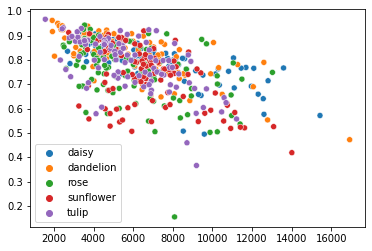

In [42]:
sns.scatterplot(x=rRed[:,0], y=rRed[:,10], hue=labels)

<AxesSubplot:>

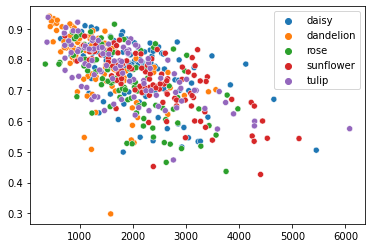

In [43]:
sns.scatterplot(x=rGreen[:,0], y=rGreen[:,10], hue=labels)

<AxesSubplot:>

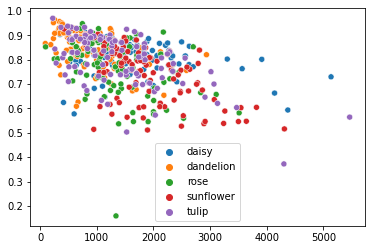

In [44]:
sns.scatterplot(x=rBlue[:,0], y=rBlue[:,10], hue=labels)

In [45]:
def aplicaPCA(features):
    pca = PCA()
    pca.fit(features)
    transform = pca.transform(features)
    print(np.sum(pca.explained_variance_ratio_[0:3]))
    return transform

In [46]:
transRed = aplicaPCA(rRed)
transGreen = aplicaPCA(rGreen)
transBlue = aplicaPCA(rBlue)

0.9999978896429804
0.9999987118021013
0.9999975038273763


# Classification

- Dividir o espaço de atributos em regiões;
- A quantidade de regiões é o número de classes;
- A acurácia da classificação está diretamente liga à qualidade dos atributos.

### Train/Test

In [47]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import cohen_kappa_score, make_scorer, confusion_matrix,accuracy_score
from sklearn.svm import SVC

In [48]:
def classificationForest(X,y, t=0.9):
    """ com random forest """
    # separar conjuntos de treino e teste
    X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=t,shuffle=True, random_state=42)
    # criar instancia do classificador
    clf = RandomForestClassifier()
    # treinar o classificador
    clf.fit(X_train,y_train)
    # realizar a predicao
    pred = clf.predict(X_test)
    # calcular o resultado utilizando a acuracia
    acuracia = acc(y_test,pred)
    return acuracia

In [49]:
def classificationXBR(X, y, t=0.9):
    X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=t,shuffle=True)
    # criar instancia do classificador
    clf = xgb.XGBClassifier()
    # treinar o classificador
    clf.fit(X_train,y_train)
    # realizar a predicao
    pred = clf.predict(X_test)
    # calcular o resultado utilizando a acuracia
    acuracia = acc(y_test,pred)
    return acuracia

In [50]:
rRedAc = []
for i in [0.6, 0.7, 0.8, 0.9]:
    rRedAc.append(
        {
            "Original": {
                'rf': classificationForest(rRed, labelsInt, t=i),
                'xbr': classificationXBR(rRed, labelsInt, t=i)
            },
            "Transform": {
                'rf': classificationForest(transRed, labelsInt, t=i),
                'xbr': classificationXBR(transRed, labelsInt, t=i)
            }
        }
    )

rRedAc

[{'Original': {'rf': 0.55, 'xbr': 0.48},
  'Transform': {'rf': 0.665, 'xbr': 0.6}},
 {'Original': {'rf': 0.6066666666666667, 'xbr': 0.5266666666666666},
  'Transform': {'rf': 0.6466666666666666, 'xbr': 0.5666666666666667}},
 {'Original': {'rf': 0.63, 'xbr': 0.52},
  'Transform': {'rf': 0.62, 'xbr': 0.59}},
 {'Original': {'rf': 0.7, 'xbr': 0.66},
  'Transform': {'rf': 0.66, 'xbr': 0.78}}]

In [51]:
rGreenAc = []
for i in [0.6, 0.7, 0.8, 0.9]:
    rGreenAc.append(
        {
            "Original": {
                'rf': classificationForest(rGreen, labelsInt, t=i),
                'xbr': classificationXBR(rGreen, labelsInt, t=i)
            },
            "Transform": {
                'rf': classificationForest(transGreen, labelsInt, t=i),
                'xbr': classificationXBR(transGreen, labelsInt, t=i)
            }
        }
    )

rGreenAc

[{'Original': {'rf': 0.51, 'xbr': 0.51},
  'Transform': {'rf': 0.58, 'xbr': 0.575}},
 {'Original': {'rf': 0.56, 'xbr': 0.5133333333333333},
  'Transform': {'rf': 0.6133333333333333, 'xbr': 0.6466666666666666}},
 {'Original': {'rf': 0.6, 'xbr': 0.59},
  'Transform': {'rf': 0.62, 'xbr': 0.62}},
 {'Original': {'rf': 0.56, 'xbr': 0.54},
  'Transform': {'rf': 0.62, 'xbr': 0.58}}]

In [52]:
rBlueAc = []
for i in [0.6, 0.7, 0.8, 0.9]:
    rBlueAc.append(
        {
            "Original": {
                'rf': classificationForest(rBlue, labelsInt, t=i),
                'xbr': classificationXBR(rBlue, labelsInt, t=i)
            },
            "Transform": {
                'rf': classificationForest(transBlue, labelsInt, t=i),
                'xbr': classificationXBR(transBlue, labelsInt, t=i)
            }
        }
    )

rBlueAc

[{'Original': {'rf': 0.515, 'xbr': 0.505},
  'Transform': {'rf': 0.64, 'xbr': 0.59}},
 {'Original': {'rf': 0.5333333333333333, 'xbr': 0.52},
  'Transform': {'rf': 0.6866666666666666, 'xbr': 0.6133333333333333}},
 {'Original': {'rf': 0.52, 'xbr': 0.56},
  'Transform': {'rf': 0.7, 'xbr': 0.58}},
 {'Original': {'rf': 0.52, 'xbr': 0.48},
  'Transform': {'rf': 0.74, 'xbr': 0.62}}]

# Grid Seach

In [71]:
def aplicaGS_randomForest(imgs, labels, test_size=0.20):
    #para treinar o classificador
    x_train, x_test, y_train, y_test = train_test_split(imgs,labels, test_size=test_size, random_state=42)

    #criar instancia do classificador
    clf = RandomForestClassifier()

    #definir os parametros a serem testados
    param_grid = {
        'n_estimators': [90,100,110,120,150,200,300]
    }

    #criar instancia do grid search
    grid = GridSearchCV(
        clf,
        param_grid,
        scoring = 'accuracy',
        cv = 10,
        n_jobs=-1
    )

    #treinar o classificador
    grid.fit(x_train, y_train)

    return grid.best_params_

In [74]:
def aplicaGS_xbr(imgs, labels, test_size=0.2):
    #para treinar o classificador
    x_train, x_test, y_train, y_test = train_test_split(imgs,labels, test_size=test_size, random_state=42)

    #criar instancia do classificador
    clf = xgb.XGBClassifier()



    #definir os parametros a serem testados
    param_grid = {
        'n_estimators': [90,100,110,120,150,200,300]
    }

    #criar instancia do grid search
    grid = GridSearchCV(
        clf,
        param_grid,
        scoring = 'accuracy',
        cv = 10,
        n_jobs=-1
    )

    #treinar o classificador
    grid.fit(x_train, y_train)

    return grid.best_params_

In [75]:
redParams = {
    'rf': aplicaGS_randomForest(rRed, labelsInt),
    'xbr': aplicaGS_xbr(rRed, labelsInt)
}

In [76]:
redParams

{'rf': {'n_estimators': 110}, 'xbr': {'n_estimators': 300}}

# Cross Validation

## Random Forest

In [82]:
def crossValidationRF(imgs, labels, bestPrms, test=0.2):
    # para treinar o classificador
    x_train, x_test, y_train, y_test = train_test_split(imgs,labels, test_size=test, random_state=42)
    
    # criar instancia do classificador
    clf = RandomForestClassifier(n_estimators=bestPrms['rf']['n_estimators'])
    
    # treinar o classificador
    clf.fit(x_train, y_train)

    # realizar a predicao
    pred = clf.predict(x_test)

    # calcular o resultado utilizando a acuracia
    acuracia = acc(y_test,pred)

    # Criar as métricas
    metrics = ['accuracy','precision','recall','f1']

    # Criar o dicionário de resultados
    scores_rf = cross_validate(clf,imgs,labels,cv=10, scoring=metrics)

    kappa = make_scorer(cohen_kappa_score)

    scores_rf_kappa = cross_validate(clf,imgs,labels,cv=10, scoring=kappa)

    clear_output(wait=True)
    return acuracia, scores_rf, scores_rf_kappa

In [ ]:
acRf, scoresRf, scoresRfKappa = crossValidationRF(transRed, labelsInt, redParams)

In [88]:
acRf

0.63

In [90]:
scoresRf

{'fit_time': array([0.17589664, 0.21879745, 0.25352263, 0.16421342, 0.18328333,
        0.17943287, 0.17121649, 0.15872598, 0.17228746, 0.16243339]),
 'score_time': array([0.00965786, 0.01275992, 0.01219106, 0.0083952 , 0.00878978,
        0.00867128, 0.00721598, 0.00846863, 0.00817776, 0.00887394]),
 'test_accuracy': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 'test_precision': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 'test_recall': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 'test_f1': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])}

In [89]:
scoresRfKappa

{'fit_time': array([0.17194748, 0.15019035, 0.15505672, 0.15379357, 0.16882253,
        0.18986964, 0.18505692, 0.18057966, 0.17344809, 0.17055297]),
 'score_time': array([0.00787544, 0.0059557 , 0.00755477, 0.00719261, 0.00802326,
        0.00856018, 0.00848174, 0.00836134, 0.00747466, 0.00921917]),
 'test_score': array([0.475, 0.525, 0.525, 0.5  , 0.425, 0.6  , 0.475, 0.6  , 0.55 ,
        0.625])}